## Central Türkiye Earthquakes (2023)

The PyGMTSAR InSAR library, Geomed3D Geophysical Inversion Library, N-Cube 3D/4D GIS Data Visualization, among others, are my open-source projects developed in my free time. I hold a Master's degree in STEM, specializing in radio physics. In 2004, I received the first prize in the All-Russian Physics Competition for significant results in forward and inverse modeling for nonlinear optics and holography. These skills are also applicable to modeling Gravity, Magnetic, and Thermal fields, as well as satellite interferometry processing. With 20 years of experience as a data scientist and software developer, I have contributed to scientific and industrial development, working on government contracts, university projects, and with companies like LG Corp and Google Inc.

You can support my work on [Patreon](https://www.patreon.com/pechnikov), where I share updates on my projects, publications, use cases, examples, and other useful information. For research and development services and support, please visit my profile on the freelance platform [Upwork](https://www.upwork.com).

### Resources
- Google Colab Pro notebooks and articles on [Patreon](https://www.patreon.com/pechnikov),
- Google Colab notebooks on [GitHub](https://github.com),
- Docker Images on [DockerHub](https://hub.docker.com),
- Geological Models on [YouTube](https://www.youtube.com),
- VR/AR Geological Models on [GitHub](https://github.com),
- Live updates and announcements on [LinkedIn](https://www.linkedin.com/in/alexey-pechnikov/).

© Alexey Pechnikov, 2024

$\large\color{blue}{\text{Hint: Use menu Cell} \to \text{Run All or Runtime} \to \text{Complete All or Runtime} \to \text{Run All}}$
$\large\color{blue}{\text{(depending of your localization settings) to execute the entire notebook}}$

## Google Colab Installation

Install PyGMTSAR and required GMTSAR binaries (including SNAPHU)

In [1]:
import platform, sys, os
if 'google.colab' in sys.modules:
    # install PyGMTSAR stable version from PyPI
    !{sys.executable} -m pip install -q pygmtsar
    # alternatively, install PyGMTSAR development version from GitHub
    #!{sys.executable} -m pip install -Uq git+https://github.com/mobigroup/gmtsar.git@pygmtsar2#subdirectory=pygmtsar 'scipy==1.11.4'
    # use PyGMTSAR Google Colab installation script to install binary dependencies
    # script URL: https://github.com/AlexeyPechnikov/pygmtsar/blob/pygmtsar2/pygmtsar/pygmtsar/data/google_colab.sh
    import importlib.resources as resources
    with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:
        !sh {google_colab_script_filename}
    # enable custom widget manager as required by recent Google Colab updates
    from google.colab import output
    output.enable_custom_widget_manager()
    # initialize virtual framebuffer for interactive 3D visualization; required for headless environments
    import xvfbwrapper
    display = xvfbwrapper.Xvfb(width=800, height=600)
    display.start()

# specify GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

# display PyGMTSAR version
from pygmtsar import __version__
__version__



env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/usr/local/GMTSAR/bin/


'2025.4.8.post1'

## Load and Setup Python Modules

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import shapely
from dask.distributed import Client
import psutil
import dask

In [3]:
# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension(comms='ipywidgets')
panel.extension('vtk')
from contextlib import contextmanager
import matplotlib.pyplot as plt
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

In [4]:
# define Pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles, datagrid
datagrid.chunksize = 4096

# recent Google Colab changes in early September 2025 broke Dask+Xarray NetCDF multithedded processing (again)
# workaround below disables multitheading when it does not work, degrading performance and increasing RAM usage.
if 'google.colab' in sys.modules:
    methods = {
        "load_dem":  "synchronous",
        "save_cube": "compute",
        "save_stack":"compute",
    }
    for m, kind in methods.items():
        if not hasattr(Stack, f"_{m}"):
            setattr(Stack, f"_{m}", getattr(Stack, m))
        def _make_wrapper(name, kind):
            orig = getattr(Stack, f"_{name}")
            if kind == "synchronous":
                def _wrapper(self, *args, **kwargs):
                    with dask.config.set(scheduler="synchronous"):
                        return orig(self, *args, **kwargs)
                return _wrapper
            elif kind == "compute":
                def _wrapper(self, *args, **kwargs):
                    if args:
                        return orig(self, args[0].compute() if hasattr(args[0], "compute") else args[0], *args[1:], **kwargs)
                    return orig(self, **kwargs)
                return _wrapper
            else:
                raise NotImplementedError(f"Unknown wrapper kind: {kind}")
        setattr(Stack, m, _make_wrapper(m, kind))

## Define Sentinel-1 SLC Scenes and Processing Parameters

When you need more scenes and SBAS analysis  see examples on PyGMTSAR GitHub page https://github.com/mobigroup/gmtsar

### Descending Orbit Configuration

https://search.asf.alaska.edu/#/?start=2023-01-19T17:00:00Z&resultsLoaded=true&granule=S1A_IW_SLC__1SDV_20230210T033451_20230210T033518_047168_05A8CD_E5B0-SLC&zoom=5.039&center=34.891,27.316&end=2023-02-10T16:59:59Z&productTypes=SLC&path=21-&frame=465-471

In [6]:
POLARIZATION = 'VV'
ORBIT        = 'D'
SUBSWATH     = 123

In [7]:
# # Path 21 Frames 465 - 471
# SCENES = """
# S1A_IW_SLC__1SDV_20230129T033427_20230129T033455_046993_05A2FE_6FF2
# S1A_IW_SLC__1SDV_20230129T033452_20230129T033519_046993_05A2FE_BE0B
# S1A_IW_SLC__1SDV_20230210T033426_20230210T033454_047168_05A8CD_FAA6
# S1A_IW_SLC__1SDV_20230210T033451_20230210T033518_047168_05A8CD_E5B0
# """
# SCENES = list(filter(None, SCENES.split('\n')))
# print (f'Scenes defined: {len(SCENES)}')

https://search.asf.alaska.edu/#/?polygon=LINESTRING(35.7%2036,37%2038.8,36.7%2035.8,38.7%2038.5,38%2035.5)&searchType=Geographic%20Search&searchList=S1A_IW_SLC__1SDV_20230129T033427_20230129T033455_046993_05A2FE_6FF2,S1A_IW_SLC__1SDV_20230129T033452_20230129T033519_046993_05A2FE_BE0B,S1A_IW_SLC__1SDV_20230210T033426_20230210T033454_047168_05A8CD_FAA6,S1A_IW_SLC__1SDV_20230210T033451_20230210T033518_047168_05A8CD_E5B0&resultsLoaded=true&granule=S1_043820_IW1_20230129T033512_VV_BE0B-BURST&zoom=6.843&center=36.353,34.829&start=2023-01-28T17:00:00Z&end=2023-02-10T16:59:59Z&flightDirs=Descending&dataset=SENTINEL-1%20BURSTS&path=21-21&beamModes=IW&polarizations=VV

In [8]:
BURSTS = """
S1_043822_IW1_20230210T033516_VV_D767-BURST
S1_043821_IW3_20230210T033515_VV_E5B0-BURST
S1_043821_IW2_20230210T033514_VV_E5B0-BURST
S1_043821_IW1_20230210T033513_VV_E5B0-BURST
S1_043820_IW3_20230210T033513_VV_E5B0-BURST
S1_043820_IW2_20230210T033512_VV_E5B0-BURST
S1_043820_IW1_20230210T033511_VV_E5B0-BURST
S1_043819_IW3_20230210T033510_VV_E5B0-BURST
S1_043819_IW2_20230210T033509_VV_E5B0-BURST
S1_043819_IW1_20230210T033508_VV_E5B0-BURST
S1_043818_IW3_20230210T033507_VV_E5B0-BURST
S1_043818_IW2_20230210T033506_VV_E5B0-BURST
S1_043818_IW1_20230210T033505_VV_E5B0-BURST
S1_043817_IW3_20230210T033504_VV_E5B0-BURST
S1_043817_IW2_20230210T033503_VV_E5B0-BURST
S1_043817_IW1_20230210T033502_VV_E5B0-BURST
S1_043816_IW3_20230210T033502_VV_E5B0-BURST
S1_043816_IW2_20230210T033501_VV_E5B0-BURST
S1_043816_IW1_20230210T033500_VV_E5B0-BURST
S1_043815_IW3_20230210T033459_VV_E5B0-BURST
S1_043815_IW2_20230210T033458_VV_E5B0-BURST
S1_043815_IW1_20230210T033457_VV_E5B0-BURST
S1_043814_IW3_20230210T033456_VV_E5B0-BURST
S1_043814_IW2_20230210T033455_VV_E5B0-BURST
S1_043814_IW1_20230210T033454_VV_E5B0-BURST
S1_043813_IW3_20230210T033453_VV_E5B0-BURST
S1_043813_IW2_20230210T033452_VV_E5B0-BURST
S1_043813_IW1_20230210T033451_VV_E5B0-BURST
S1_043812_IW3_20230210T033451_VV_FAA6-BURST
S1_043812_IW2_20230210T033450_VV_FAA6-BURST
S1_043812_IW1_20230210T033449_VV_FAA6-BURST
S1_043811_IW3_20230210T033448_VV_FAA6-BURST
S1_043811_IW2_20230210T033447_VV_FAA6-BURST
S1_043811_IW1_20230210T033446_VV_FAA6-BURST
S1_043810_IW3_20230210T033445_VV_FAA6-BURST
S1_043810_IW2_20230210T033444_VV_FAA6-BURST
S1_043810_IW1_20230210T033443_VV_FAA6-BURST
S1_043809_IW3_20230210T033442_VV_FAA6-BURST
S1_043809_IW2_20230210T033441_VV_FAA6-BURST
S1_043809_IW1_20230210T033440_VV_FAA6-BURST
S1_043808_IW3_20230210T033439_VV_FAA6-BURST
S1_043808_IW2_20230210T033439_VV_FAA6-BURST
S1_043808_IW1_20230210T033438_VV_FAA6-BURST
S1_043807_IW3_20230210T033437_VV_FAA6-BURST
S1_043807_IW2_20230210T033436_VV_FAA6-BURST
S1_043807_IW1_20230210T033435_VV_FAA6-BURST
S1_043806_IW3_20230210T033434_VV_FAA6-BURST
S1_043806_IW2_20230210T033433_VV_FAA6-BURST
S1_043806_IW1_20230210T033432_VV_FAA6-BURST
S1_043805_IW3_20230210T033431_VV_FAA6-BURST
S1_043805_IW2_20230210T033430_VV_FAA6-BURST
S1_043805_IW1_20230210T033429_VV_FAA6-BURST
S1_043804_IW3_20230210T033428_VV_FAA6-BURST
S1_043804_IW2_20230210T033427_VV_FAA6-BURST
S1_043804_IW1_20230210T033427_VV_FAA6-BURST
S1_043803_IW3_20230210T033426_VV_FAA6-BURST
S1_043822_IW1_20230129T033517_VV_E089-BURST
S1_043821_IW3_20230129T033516_VV_BE0B-BURST
S1_043821_IW2_20230129T033515_VV_BE0B-BURST
S1_043821_IW1_20230129T033514_VV_BE0B-BURST
S1_043820_IW3_20230129T033513_VV_BE0B-BURST
S1_043820_IW2_20230129T033512_VV_BE0B-BURST
S1_043820_IW1_20230129T033512_VV_BE0B-BURST
S1_043819_IW3_20230129T033511_VV_BE0B-BURST
S1_043819_IW2_20230129T033510_VV_BE0B-BURST
S1_043819_IW1_20230129T033509_VV_BE0B-BURST
S1_043818_IW3_20230129T033508_VV_BE0B-BURST
S1_043818_IW2_20230129T033507_VV_BE0B-BURST
S1_043818_IW1_20230129T033506_VV_BE0B-BURST
S1_043817_IW3_20230129T033505_VV_BE0B-BURST
S1_043817_IW2_20230129T033504_VV_BE0B-BURST
S1_043817_IW1_20230129T033503_VV_BE0B-BURST
S1_043816_IW3_20230129T033502_VV_BE0B-BURST
S1_043816_IW2_20230129T033501_VV_BE0B-BURST
S1_043816_IW1_20230129T033501_VV_BE0B-BURST
S1_043815_IW3_20230129T033500_VV_BE0B-BURST
S1_043815_IW2_20230129T033459_VV_BE0B-BURST
S1_043815_IW1_20230129T033458_VV_BE0B-BURST
S1_043814_IW3_20230129T033457_VV_BE0B-BURST
S1_043814_IW2_20230129T033456_VV_BE0B-BURST
S1_043814_IW1_20230129T033455_VV_BE0B-BURST
S1_043813_IW3_20230129T033454_VV_BE0B-BURST
S1_043813_IW2_20230129T033453_VV_BE0B-BURST
S1_043813_IW1_20230129T033452_VV_BE0B-BURST
S1_043812_IW3_20230129T033451_VV_6FF2-BURST
S1_043812_IW2_20230129T033450_VV_6FF2-BURST
S1_043812_IW1_20230129T033449_VV_6FF2-BURST
S1_043811_IW3_20230129T033449_VV_6FF2-BURST
S1_043811_IW2_20230129T033448_VV_6FF2-BURST
S1_043811_IW1_20230129T033447_VV_6FF2-BURST
S1_043810_IW3_20230129T033446_VV_6FF2-BURST
S1_043810_IW2_20230129T033445_VV_6FF2-BURST
S1_043810_IW1_20230129T033444_VV_6FF2-BURST
S1_043809_IW3_20230129T033443_VV_6FF2-BURST
S1_043809_IW2_20230129T033442_VV_6FF2-BURST
S1_043809_IW1_20230129T033441_VV_6FF2-BURST
S1_043808_IW3_20230129T033440_VV_6FF2-BURST
S1_043808_IW2_20230129T033439_VV_6FF2-BURST
S1_043808_IW1_20230129T033438_VV_6FF2-BURST
S1_043807_IW3_20230129T033438_VV_6FF2-BURST
S1_043807_IW2_20230129T033437_VV_6FF2-BURST
S1_043807_IW1_20230129T033436_VV_6FF2-BURST
S1_043806_IW3_20230129T033435_VV_6FF2-BURST
S1_043806_IW2_20230129T033434_VV_6FF2-BURST
S1_043806_IW1_20230129T033433_VV_6FF2-BURST
S1_043805_IW3_20230129T033432_VV_6FF2-BURST
S1_043805_IW2_20230129T033431_VV_6FF2-BURST
S1_043805_IW1_20230129T033430_VV_6FF2-BURST
S1_043804_IW3_20230129T033429_VV_6FF2-BURST
S1_043804_IW2_20230129T033428_VV_6FF2-BURST
S1_043804_IW1_20230129T033427_VV_6FF2-BURST
S1_043803_IW3_20230129T033427_VV_6FF2-BURST
"""
BURSTS = list(filter(None, BURSTS.split('\n')))
print (f'Bursts defined: {len(BURSTS)}')

Bursts defined: 112


In [9]:
WORKDIR      = 'raw_kahr'
DATADIR      = 'data_kahr'
# output resolution defined as float value, meter
RESOLUTION   = 180.

In [10]:
# define DEM and landmask filenames inside data directory
DEM = f'{DATADIR}/dem.nc'
LANDMASK = f'{DATADIR}/landmask.nc'

In [11]:
# Magnitude Mw 7.8 & 7.5
# Region    CENTRAL TURKEY
# Date      2023-02-06
EPICENTERS = [37.24, 38.11,37.08, 37.17]
POI = gpd.GeoDataFrame(geometry=[shapely.geometry.Point(coord) for coord in np.reshape(EPICENTERS, (2,-1))])
POI

,geometry
0,POINT (37.24 38.11)
1,POINT (37.08 37.17)


## Download and Unpack Datasets (Optional)

## Enter Your ASF User and Password

If the data directory is empty or doesn't exist, you'll need to download Sentinel-1 scenes from the Alaska Satellite Facility (ASF) datastore. Use your Earthdata Login credentials. If you don't have an Earthdata Login, you can create one at https://urs.earthdata.nasa.gov//users/new

You can also use pre-existing SLC scenes stored on your Google Drive, or you can copy them using a direct public link from iCloud Drive.

The credentials below are available at the time the notebook is validated.

In [12]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf_username = 'GoogleColab2023'
asf_password = 'GoogleColab_2023'

In [13]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf = ASF(asf_username, asf_password)
# Optimized scene downloading from ASF - only the required subswaths and polarizations.
# Subswaths are already encoded in burst identifiers and are only needed for scenes.
#print(asf.download(DATADIR, SCENES, SUBSWATH))
print(asf.download(DATADIR, BURSTS))

ASF Downloading Bursts Catalog:   0%|          | 0/1 [00:00<?, ?it/s]

ASF Downloading Sentinel-1 SLC Bursts:   0%|          | 0/112 [00:00<?, ?it/s]

                                  burst_or_scene
0    S1_043822_IW1_20230210T033516_VV_D767-BURST
1    S1_043821_IW3_20230210T033515_VV_E5B0-BURST
2    S1_043821_IW2_20230210T033514_VV_E5B0-BURST
3    S1_043821_IW1_20230210T033513_VV_E5B0-BURST
4    S1_043820_IW3_20230210T033513_VV_E5B0-BURST
5    S1_043820_IW2_20230210T033512_VV_E5B0-BURST
6    S1_043820_IW1_20230210T033511_VV_E5B0-BURST
7    S1_043819_IW3_20230210T033510_VV_E5B0-BURST
8    S1_043819_IW2_20230210T033509_VV_E5B0-BURST
9    S1_043819_IW1_20230210T033508_VV_E5B0-BURST
10   S1_043818_IW3_20230210T033507_VV_E5B0-BURST
11   S1_043818_IW2_20230210T033506_VV_E5B0-BURST
12   S1_043818_IW1_20230210T033505_VV_E5B0-BURST
13   S1_043817_IW3_20230210T033504_VV_E5B0-BURST
14   S1_043817_IW2_20230210T033503_VV_E5B0-BURST
15   S1_043817_IW1_20230210T033502_VV_E5B0-BURST
16   S1_043816_IW3_20230210T033502_VV_E5B0-BURST
17   S1_043816_IW2_20230210T033501_VV_E5B0-BURST
18   S1_043816_IW1_20230210T033500_VV_E5B0-BURST
19   S1_043815_IW3_2

In [14]:
# scan the data directory for SLC scenes and download missed orbits
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes
NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.


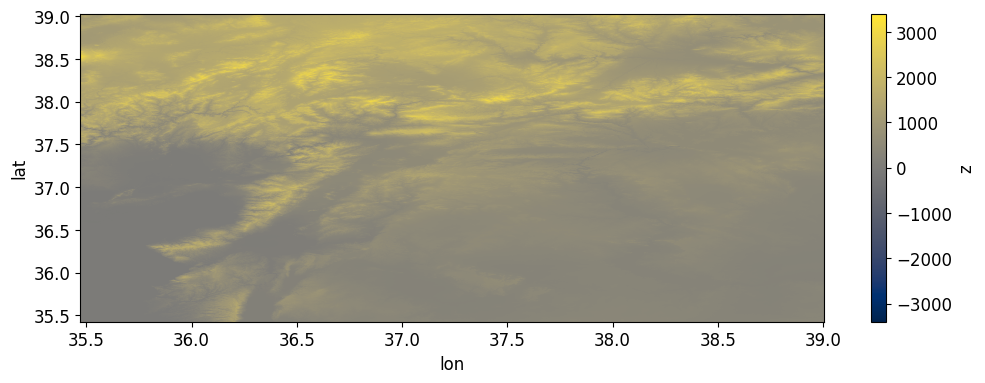

In [15]:
# Define AOI as the whole scenes extent.
AOI = S1.scan_slc(DATADIR)
# download Copernicus Global DEM 1 arc-second
Tiles().download_dem(AOI, filename=DEM, product='3s').plot.imshow(cmap='cividis')

NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.


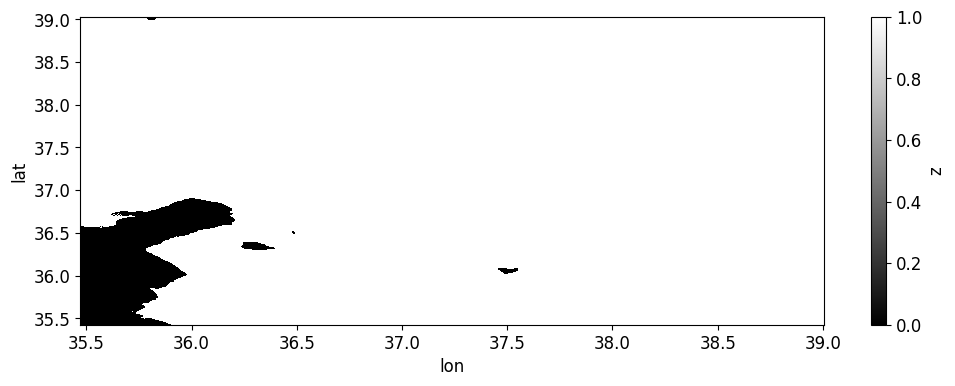

In [16]:
# download land mask 1 arc-second
Tiles().download_landmask(AOI, filename=LANDMASK, product='3s').fillna(0).plot.imshow(cmap='binary_r')

## Run Local Dask Cluster

Launch Dask cluster for big data processing. Use "Dashboard" link below for the local cluster state and execution monitoring.

In [17]:
# cleanup for repeatable runs
if 'client' in globals():
    client.close()
# tune to use 4 cores per worker and allocate only the available RAM
# swap is not allowed on Google Colab and is typically small in Docker containers (0.5 - 1GB by default),
# so we rely entirely on available physical memory in such environments.
client = Client(n_workers=max(1, psutil.cpu_count() // 2))
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:32915
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36217'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33571'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38283'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36831'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42201'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45373'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:46589 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46589
INFO:distributed.core

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 52.96 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32915,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44623,Total threads: 2
Dashboard: http://127.0.0.1:44457/status,Memory: 8.83 GiB
Nanny: tcp://127.0.0.1:36217,


## Init SBAS

Search recursively for measurement (.tiff) and annotation (.xml) and orbit (.EOF) files in the DATA directory. It can be directory with full unzipped scenes (.SAFE) subdirectories or just a directory with the list of pairs of required .tiff and .xml files (maybe pre-filtered for orbit, polarization and subswath to save disk space). If orbit files and DEM are missed these will be downloaded automatically below.

### Select Original Secenes and Download DEM and Orbits Later

Use filters to find required subswath, polarization and orbit in original scenes .SAFE directories in the data directory.

In [18]:
scenes = S1.scan_slc(DATADIR, polarization=POLARIZATION, orbit=ORBIT)

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


In [19]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes)
sbas.to_dataframe()

NOTE: auto set reference scene 2023-01-29. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,noisepath,calibpath,orbitpath,geometry
date,,,,,,,,,,,
2023-01-29,2023-01-29 03:34:27,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033427_20230129T033430_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033427_20230129T033430_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULTIPOLYGON (((39.00478 38.5783, 38.94569 38.58717, 38.8843 38.59636, 38.82853 38.60468, 38.773..."
2023-01-29,2023-01-29 03:34:30,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033430_20230129T033433_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033430_20230129T033433_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULTIPOLYGON (((38.96538 38.41224, 38.90387 38.4215, 38.85385 38.42901, 38.80104 38.43691, 38.74..."
2023-01-29,2023-01-29 03:34:33,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033433_20230129T033436_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033433_20230129T033436_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULTIPOLYGON (((38.91431 38.24781, 38.86873 38.25469, 38.80432 38.26437, 38.7488 38.27269, 38.69..."
2023-01-29,2023-01-29 03:34:36,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033436_20230129T033439_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033436_20230129T033439_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULTIPOLYGON (((38.87509 38.08186, 38.82021 38.09016, 38.76747 38.09811, 38.71335 38.10624, 38.6..."
2023-01-29,2023-01-29 03:34:38,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033438_20230129T033441_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033438_20230129T033441_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULTIPOLYGON (((38.84553 37.91433, 38.77846 37.92449, 38.72266 37.93291, 38.67083 37.94072, 38.6..."
2023-01-29,2023-01-29 03:34:41,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033441_20230129T033444_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033441_20230129T033444_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULTIPOLYGON (((38.81124 37.74764, 38.75297 37.75649, 38.69769 37.76487, 38.64202 37.77327, 38.5..."
2023-01-29,2023-01-29 03:34:44,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033444_20230129T033447_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033444_20230129T033447_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULTIPOLYGON (((38.76956 37.58207, 38.71461 37.59044, 38.65885 37.59891, 38.60332 37.60731, 38.5..."
2023-01-29,2023-01-29 03:34:47,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033447_20230129T033450_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033447_20230129T033450_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULTIPOLYGON (((38.72953 37.416, 38.67369 37.42452, 38.6187 37.43289, 38.56465 37.44109, 38.5100..."
2023-01-29,2023-01-29 03:34:49,D,S1A,VV,1,data_kahr/S1A_IW_SLC__1SDV_20230129T033449_20230129T033452_046993_05A2FE_6FF2.SAFE/measurement/s...,data_kahr/S1A_IW_SLC__1SDV_20230129T033449_20230129T033452_046993_05A2FE_6FF2.SAFE/annotation/s1...,None,None,data_kahr/S1A_OPER_AUX_POEORB_OPOD_20230218T080751_V20230128T225942_20230130T005942.EOF,"MULT

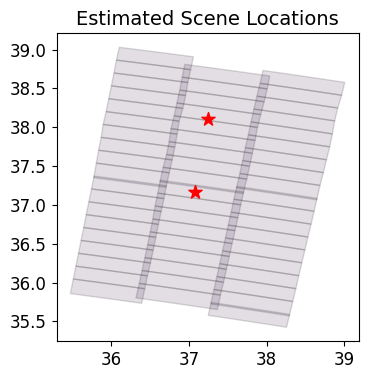

In [20]:
sbas.plot_scenes(POI=POI)

## Reframe Scenes (Optional)

Stitch sequential scenes and crop the subswath to a smaller area for faster processing when the full area is not needed.

In [21]:
sbas.compute_reframe()

Reframing:   0%|          | 0/6 [00:00<?, ?it/s]

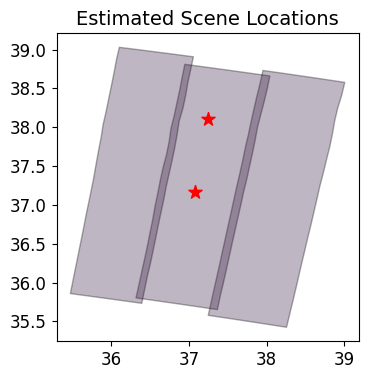

In [22]:
sbas.plot_scenes(POI=POI)

### Load DEM

The function below loads DEM from file or Xarray variable and converts heights to ellipsoidal model using EGM96 grid.

In [23]:
# define the area of interest (AOI) to speedup the processing
sbas.load_dem(DEM, AOI)

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

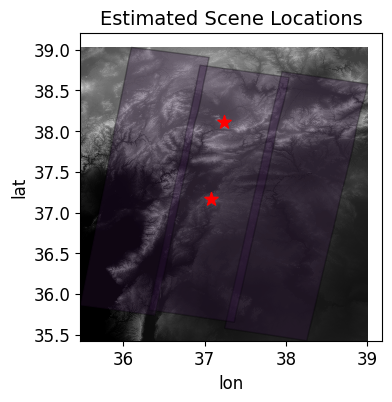

In [24]:
sbas.plot_scenes(POI=POI)
plt.savefig('Estimated Scene Locations.jpg')

## Align Images

In [25]:
if os.path.exists('/.dockerenv'):
    # adjust for Docker environments, including Google Colab instances
    sbas.compute_align(n_jobs=max(1, (psutil.cpu_count() // 2)))
else:
    sbas.compute_align()

Preparing Reference:   0%|          | 0/3 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/3 [00:00<?, ?it/s]

## Geocoding Transform

In [26]:
sbas.compute_geocode(RESOLUTION)

Radar Transform Computing:   0%|          | 0/1 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

INFO:distributed.scheduler:Receive client connection: Client-worker-f539e944-e5b4-11f0-a380-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:36262
INFO:distributed.scheduler:Receive client connection: Client-worker-f5557b87-e5b4-11f0-a377-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:36278
INFO:distributed.scheduler:Receive client connection: Client-worker-f557495c-e5b4-11f0-a379-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:36286
INFO:distributed.scheduler:Receive client connection: Client-worker-f558f0bd-e5b4-11f0-a37f-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:36288
INFO:distributed.scheduler:Receive client connection: Client-worker-f55c4e5b-e5b4-11f0-a36f-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:36300
INFO:distributed.scheduler:Receive client connection: Client-worker-f55eec87-e5b

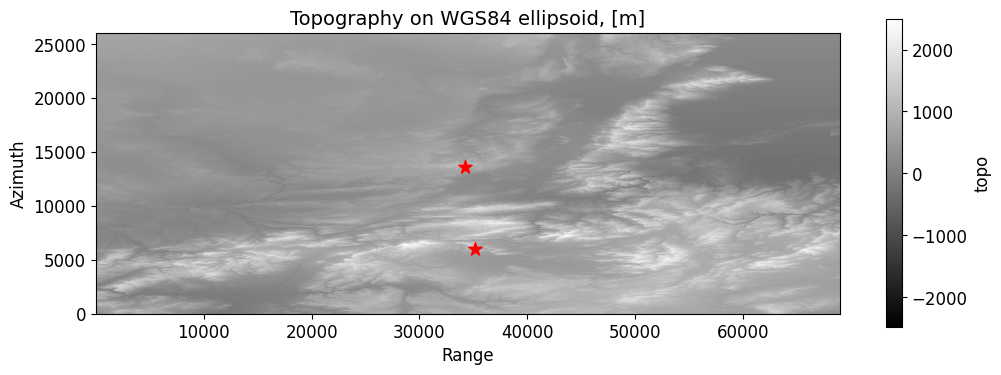

In [27]:
sbas.plot_topo(POI=sbas.geocode(POI))
plt.savefig('Topography on WGS84 ellipsoid, [m].jpg')

## Interferogram

In [28]:
# for a pair of scenes only two interferograms can be produced
# this one is selected for scenes sorted by the date in direct order
pairs = [sbas.to_dataframe().index.unique()]
pairs

[Index(['2023-01-29', '2023-02-10'], dtype='object', name='date')]

In [29]:
# prevent excessive logging
import logging
logging.getLogger("distributed.shuffle._scheduler_plugin").setLevel(logging.ERROR)
# load radar topography
topo = sbas.get_topo()
# load Sentinel-1 data
data = sbas.open_data()
# Gaussian filtering 400m cut-off wavelength with multilooking on Sentinel-1 intensity
intensity_mlook = sbas.multilooking(np.square(np.abs(data)), wavelength=400, coarsen=(12,48))
# calculate phase difference with topography correction
phase = sbas.phasediff(pairs, data, topo)
# Gaussian filtering 400m cut-off wavelength with 10x40 multilooking
phase_mlook= sbas.multilooking(phase, wavelength=400, coarsen=(12,48))
# correlation in about 180 m resolution
corr_mlook = sbas.correlation(phase_mlook, intensity_mlook)
# Goldstein filter in 16x16 multilooking pixel patch size
phase_mlook_goldstein = sbas.goldstein(phase_mlook, corr_mlook, 16)
# convert complex phase difference to interferogram
intf_mlook = sbas.interferogram(phase_mlook_goldstein)
# compute together because correlation depends on phase, and Goldstein phase depends on correlation
corr, intf = dask.persist(corr_mlook[0], intf_mlook[0])
# show progress indicator
tqdm_dask((corr, intf), desc='Compute Phase and Correlation')

Compute Phase and Correlation:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [30]:
# geocode to geographic coordinates and crop empty borders
intf_ll = sbas.ra2ll(intf)
corr_ll = sbas.ra2ll(corr)

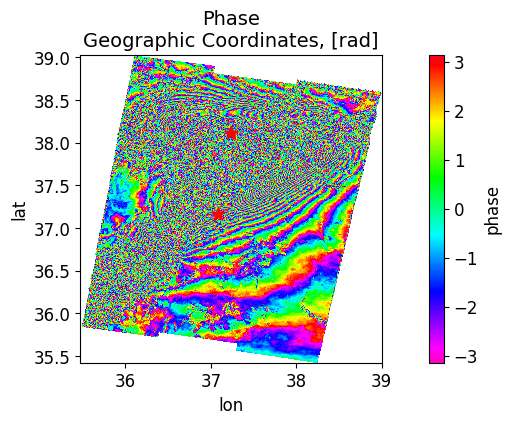

In [31]:
sbas.plot_interferogram(intf_ll, caption='Phase\nGeographic Coordinates, [rad]', POI=POI)
plt.savefig('Phase Geographic Coordinates, [rad].jpg')

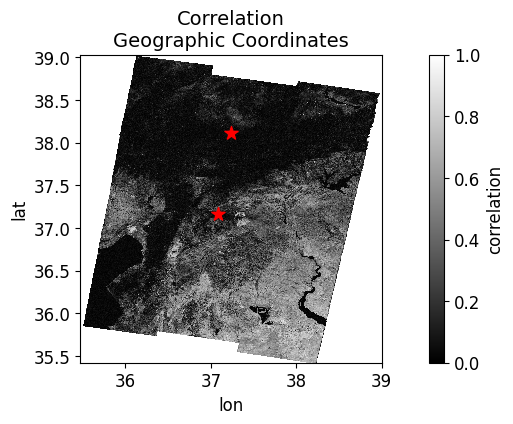

In [32]:
sbas.plot_correlation(corr_ll, caption='Correlation\nGeographic Coordinates', POI=POI)
plt.savefig('Correlation Geographic Coordinates, [rad].jpg')

## Landmask

Interferogram presents just a noise for water surfaces and unwrapping is meaningless long for these areas. Landmask allows to exclude water sufraces to produce better looking unwrapping results and much faster. Landmask in geographic coordinates is suitable to check it on the map while for unwrapping required landmask in radar coordinates.

In [33]:
sbas.load_landmask(LANDMASK)

In [34]:
landmask_ll = sbas.get_landmask().reindex_like(intf_ll, method='nearest')
landmask = sbas.ll2ra(landmask_ll).reindex_like(intf, method='nearest')

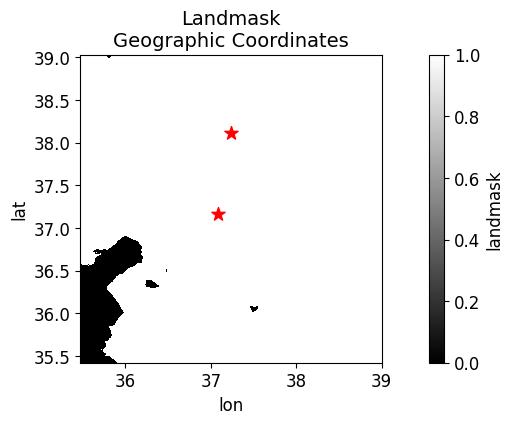

In [35]:
sbas.plot_landmask(landmask=landmask_ll, caption='Landmask\nGeographic Coordinates', POI=POI)
plt.savefig('Landmask Geographic Coordinates, [rad].jpg')

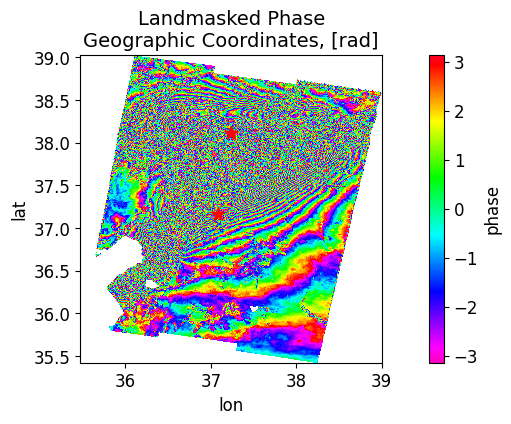

In [36]:
sbas.plot_interferogram(intf_ll.where(landmask_ll), caption='Landmasked Phase\nGeographic Coordinates, [rad]', POI=POI)
plt.savefig('Landmasked Phase Geographic Coordinates, [rad].jpg')

In [37]:
sbas.export_vtk(intf[::3,::3], 'intf', mask='auto')

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('intf.vtk').scale([1, 1, 0.00002], inplace=True), scalars='phase', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D Interferogram.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive Interferogram on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

Output hidden; open in https://colab.research.google.com to view.

## Unwrapping

Unwrapping process requires a lot of RAM and that's really RAM consuming when a lot of parallel proccesses running togeter. To limit the parallel processing tasks apply argument "n_jobs". The default value n_jobs=-1 means all the processor cores van be used. Also, use interferogram decimation above to produce smaller interferograms. And in addition a custom SNAPHU configuration can reduce RAM usage as explained below.

### Generate Custom SNAPHU Config

Default SNAPHU configuration allows to run multiple unwrapping tasks in parallel. At the same time, for a single interferogram processing or large interferograms unwrapping SNAPHU tiling can decrease the both processing time and RAM comsumption. Be careful to prevent unconnected zones on the tiles when a high coherency area is fully arounded by low-coherent buffer on some tiles (redefine tiles or increase tiles row and column overlapping parameters ROWOVRLP and COLOVRLP).

In [39]:
# small tiles unwrapping is faster but some details can be missed
conf = sbas.snaphu_config(defomax=None,
                          NTILEROW=4, NTILECOL=4,
                          ROWOVRLP=200, COLOVRLP=200)
# check the generated SNAPHU config and tune the SNAPHU parameters above if needed.
print ('SNAPHU custom config generated:')
print (conf)

SNAPHU custom config generated:

        # basic config
        INFILEFORMAT   FLOAT_DATA
        OUTFILEFORMAT  FLOAT_DATA
        AMPFILEFORMAT  FLOAT_DATA
        CORRFILEFORMAT FLOAT_DATA
        ALTITUDE       693000.0
        EARTHRADIUS    6378000.0
        NEARRANGE      831000
        DR             18.4
        DA             28.2
        RANGERES       28
        AZRES          44
        LAMBDA         0.0554658
        NLOOKSRANGE    1
        NLOOKSAZ       1
        TILEDIR        raw_kahr/2023-01-29_F1_snaphu_tiledir
        NPROC          12
        # custom config
        NTILEROW 4
        NTILECOL 4
        ROWOVRLP 200
        COLOVRLP 200



### Interferogram Unwrapping

SNAPHU unwrapper allows to split large scene to tiles for parallel processing and accurately enough merge the tiles to a single image. That's especially helpful to unwrap a single interferogram using all the processor cores and save RAM consumption drastically.

In [40]:
# Low-coherence phases can be masked using a threshold value. Offshore areas in the phase are masked.
# The masked phase is internally interpolated using the phases of the nearest pixels with good coherence.
# Pixels located far from well-coherent regions are set to zero phase during the unwrapping processing.
tqdm_dask(unwrap := sbas.unwrap_snaphu(intf.where(landmask), corr, conf=conf).persist(), desc='SNAPHU Unwrapping')

SNAPHU Unwrapping:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [41]:
# geocode to geographic coordinates and crop empty borders
unwrap_ll = sbas.ra2ll(unwrap.phase)

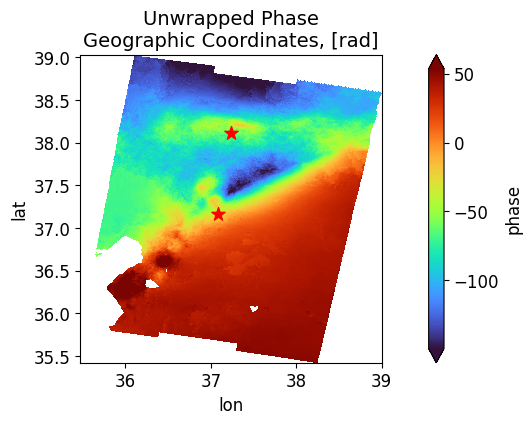

In [42]:
sbas.plot_phase(unwrap_ll, caption='Unwrapped Phase\nGeographic Coordinates, [rad]', quantile=[0.01, 0.99], POI=POI)
plt.savefig('Unwrapped Phase Geographic Coordinates, [rad].jpg')

## Detrend

In [43]:
tqdm_dask(detrend := (unwrap.phase - sbas.gaussian(unwrap.phase, wavelength=300000)).persist(),
          desc='Detrending')

Detrending:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [44]:
detrend_ll = sbas.ra2ll(detrend)

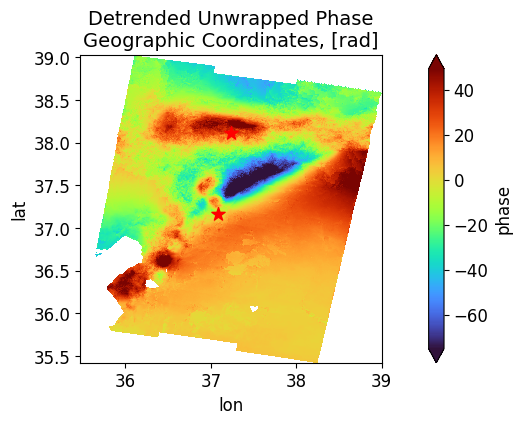

In [45]:
sbas.plot_phase(detrend_ll, caption='Detrended Unwrapped Phase\nGeographic Coordinates, [rad]', quantile=[0.01, 0.99], POI=POI)
plt.savefig('Detrended Unwrapped Phase Geographic Coordinates, [rad].jpg')

## LOS Displacement

In [46]:
# geocode to geographic coordinates
los_disp_mm_ll = sbas.ra2ll(sbas.los_displacement_mm(detrend))

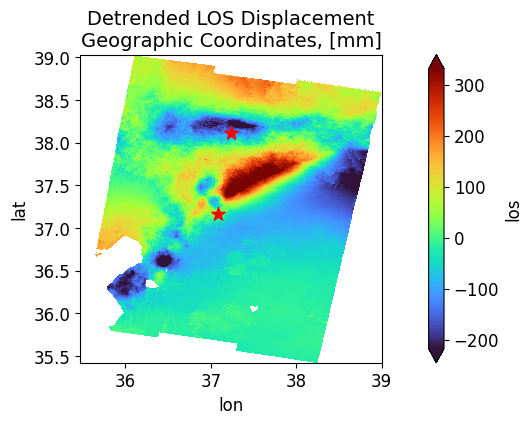

In [47]:
sbas.plot_displacement(los_disp_mm_ll, caption='Detrended LOS Displacement\nGeographic Coordinates, [mm]', quantile=[0.01, 0.99], POI=POI)
plt.savefig('Detrended LOS Displacement Geographic Coordinates, [rad].jpg')

In [48]:
sbas.export_vtk(los_disp_mm_ll[::3,::3], 'los', mask='auto')

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('los.vtk').scale([1, 1, 0.00002], inplace=True), scalars='los', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D LOS Displacement.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive LOS Displacement on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

Output hidden; open in https://colab.research.google.com to view.

## Vertical and East-West Displacements Projections

LOS displacement projections as vertical and east-west displacements can be calculated using incidence angle defined on the grid.

In [50]:
incidence_angle = sbas.incidence_angle()

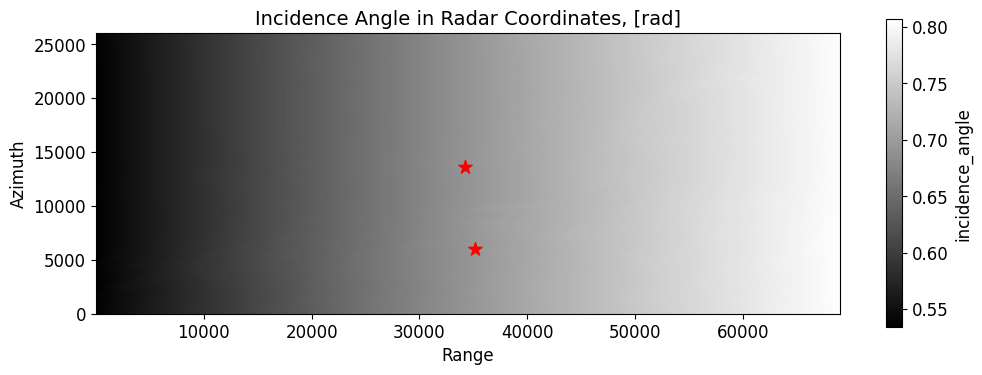

In [51]:
sbas.plot_incidence_angle(POI=sbas.geocode(POI))
plt.savefig('Incidence Angle Radar Coordinates, [rad].jpg')

In [52]:
vert_disp_mm_ll = sbas.ra2ll(sbas.vertical_displacement_mm(detrend))
east_disp_mm_ll = sbas.ra2ll(sbas.eastwest_displacement_mm(detrend))

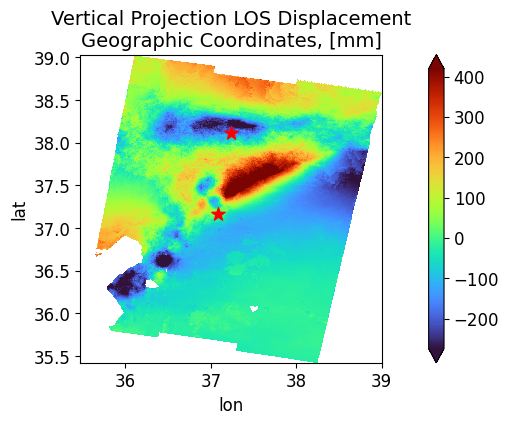

In [53]:
sbas.plot_displacement(vert_disp_mm_ll, caption='Vertical Projection LOS Displacement\nGeographic Coordinates, [mm]', quantile=[0.01, 0.99], POI=POI)
plt.savefig('Vertical Projection LOS Displacement Geographic Coordinates, [mm].jpg')

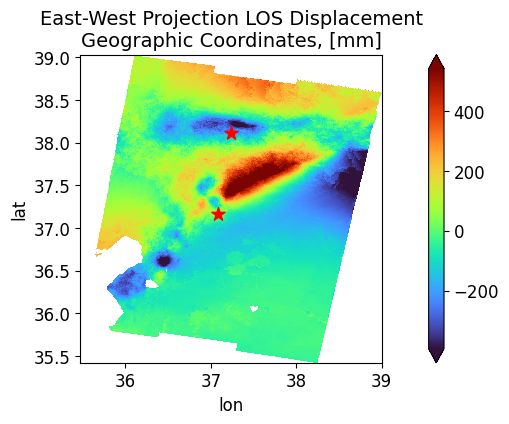

In [54]:
sbas.plot_displacement(east_disp_mm_ll, caption='East-West Projection LOS Displacement\nGeographic Coordinates, [mm]', quantile=[0.01, 0.99], POI=POI)
plt.savefig('East-West Projection LOS Displacement Geographic Coordinates, [mm].jpg')

In [55]:
sbas.export_vtk(vert_disp_mm_ll.rename('vdisp')[::3,::3], 'vdisp', mask='auto')

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('vdisp.vtk').scale([1, 1, 0.00002], inplace=True), scalars='vdisp', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D Vertical Displacement.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive Vertical Displacement on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

Output hidden; open in https://colab.research.google.com to view.

In [57]:
sbas.export_vtk(east_disp_mm_ll.rename('edisp')[::3,::3], 'edisp', mask='auto')

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [58]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('edisp.vtk').scale([1, 1, 0.00002], inplace=True), scalars='edisp', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D East-West Displacement.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive East-West Displacement on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

Output hidden; open in https://colab.research.google.com to view.